In [33]:
# Imports
from ml_utils import *
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0' #Don't print TF INFO messages

import ipywidgets as widgets
import matplotlib as mpl
from ipywidgets import interact
from pprint import pprint
import datetime
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import wandb
import yaml
from pyts.metrics import dtw

from tensorflow.keras import layers
import tensorflow as tf
from tensorflow import keras
keras.utils.set_random_seed(42)
# Set the font to computer modern
mpl.rc('font', family='serif', serif='cmr10')
mpl.rc('axes.formatter', use_mathtext=True)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
# Read in the existing config, optionally update it, and then save the result to disk again
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

config.update({
    "activation_fn": "elu",
    "batch_size": 128,
    "dropout_frac": 0.522,
    'n_hidden_units': {1: 54, 2: 150},
    "label_expansion": 10,
    "lr": 0.000261,
    'epochs': 15,
    "optimiser": "rmsprop",
    "window_size": 23,

    'center_label': True,
    'architecture': 'ffnn',
    'use_class_weights': False,
    'bias_final_layer': True,
    'use_wandb': False,
})

with open('config.yaml', 'w') as file:
    yaml.dump(config, file)
pprint(config)

{'activation': 'softmax',
 'activation_fn': 'elu',
 'architecture': 'ffnn',
 'batch_size': 128,
 'bias_final_layer': True,
 'center_label': True,
 'dropout_frac': 0.522,
 'epochs': 15,
 'g255_vs_rest': False,
 'gestures': None,
 'label_after': 10,
 'label_before': 10,
 'label_expansion': 10,
 'label_offset': 0,
 'label_size_over_window_size': 0.5,
 'loss_fn': 'sparse_categorical_crossentropy',
 'lr': 0.000261,
 'n_hidden_units': {1: 54, 2: 150},
 'omit_0255': False,
 'optimiser': 'rmsprop',
 'test_frac': 0.25,
 'use_class_weights': False,
 'use_wandb': False,
 'window_size': 23,
 'window_skip': 1}


In [35]:
path = "models/2022-11-06T18:58:15.448177/"
model = keras.models.load_model(path)

with open(f'{path}/config.yaml', 'r') as file:
    config = yaml.safe_load(file)


In [37]:
df = parse_csvs()

config, g2i, i2g, i2ohe, ohe2i, X, y, X_train, X_valid, y_train, y_valid = \
    build_dataset(df, config)

Making batches with window size of 23
Expanding labels to be in deltas of 10 before to 10 after


In [38]:
# Tensorflow Feed Forward NN
if config['use_wandb']:
    wandb.init()
history, model = compile_and_fit(
    X_train,
    y_train,
    X_valid,
    y_valid,
    config | {'epochs': 15},
    i2g,
    verbose=1,
)

2022-11-11 08:01:40.823323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-11 08:01:40.837934: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


(162167, 23, 30)
Epoch 1/15
   7/1267 [..............................] - ETA: 11s - loss: 3.7638 

2022-11-11 08:01:49.741108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1266/1267 [============================>.] - ETA: 0s - loss: 2.1007

2022-11-11 08:02:00.056938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-11 08:02:02.468101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1267/1267 [==============================] - 18s 14ms/step - loss: 2.1004 - val_loss: 1.2364
Epoch 2/15
1267/1267 [==============================] - 17s 13ms/step - loss: 1.3396 - val_loss: 0.8625
Epoch 3/15
1267/1267 [==============================] - 17s 13ms/step - loss: 1.1013 - val_loss: 0.7605
Epoch 4/15
1267/1267 [==============================] - 17s 13ms/step - loss: 0.9895 - val_loss: 0.6832
Epoch 5/15
1267/1267 [==============================] - 17s 13ms/step - loss: 0.9189 - val_loss: 0.6521
Epoch 6/15
1267/1267 [==============================] - 17s 13ms/step - loss: 0.8765 - val_loss: 0.6312
Epoch 7/15
1267/1267 [==============================] - 17s 13ms/step - loss: 0.8443 - val_loss: 0.6157
Epoch 8/15
1267/1267 [==============================] - 17s 13ms/step - loss: 0.8140 - val_loss: 0.6041
Epoch 9/15
1267/1267 [==============================] - 17s 14ms/step - loss: 0.7993 - val_loss: 0.5982
Epoch 10/15
1267/1267 [==============================] - 17s 13ms/step - lo

Percentage g255:  [0.52051897]
Saving model
INFO:tensorflow:Assets written to: ./models/2022-11-11T08:05:42.124223/assets
Making plots


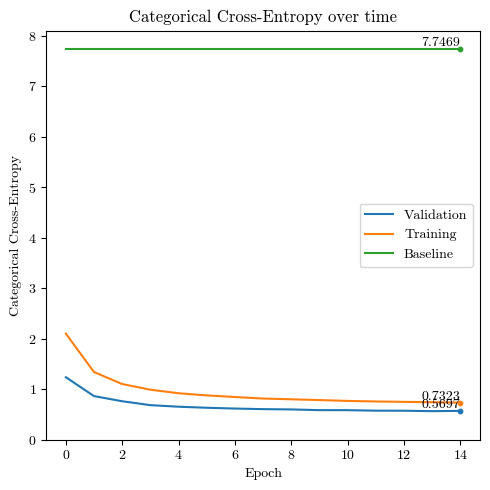

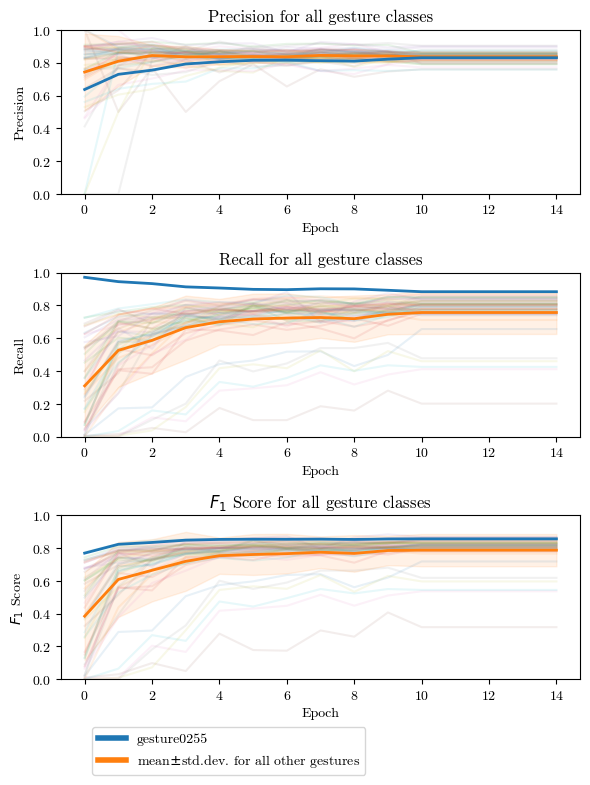

Making predictions and confusion matrix


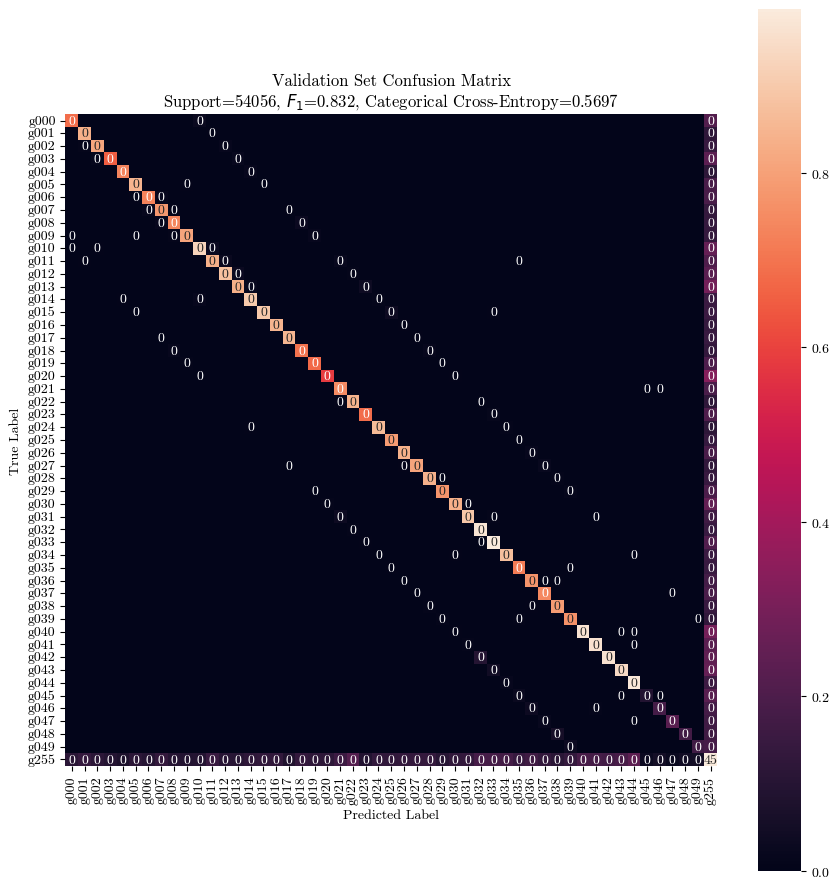

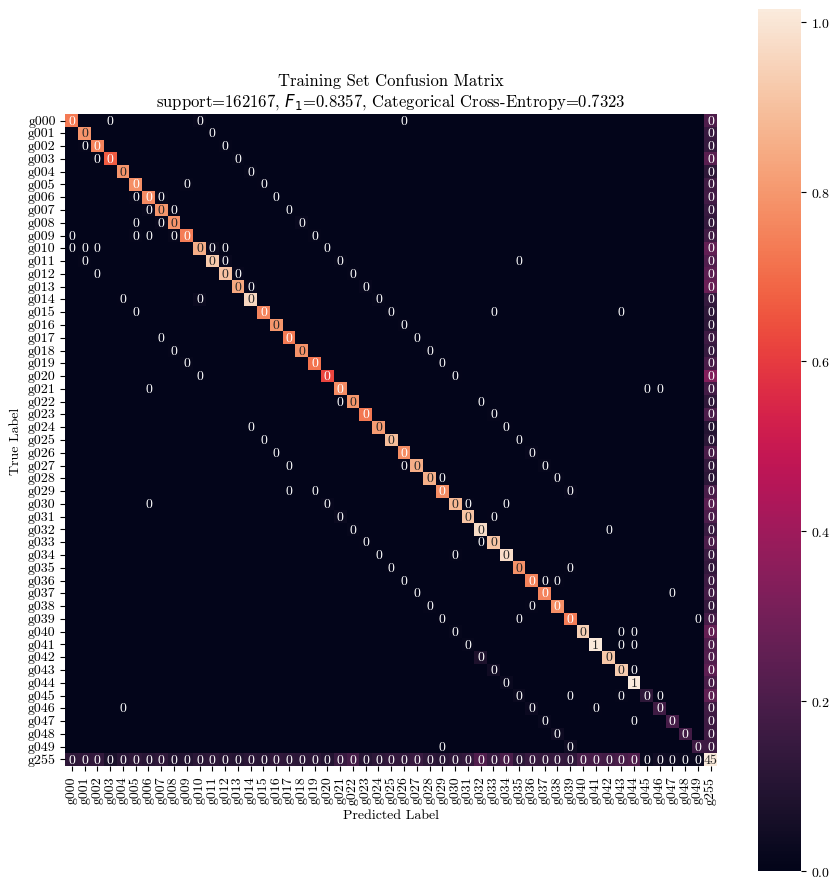

In [39]:
print('Percentage g255: ', (y_train == g2i('gesture0255')).sum() / y_train.shape)
eval_and_save(`
    model, 
    X_train, 
    y_train, 
    X_valid, 
    y_valid, 
    config,
    i2g,
    history, 
    show_figs=True, 
    cbar=True, 
    make_plots=True,
    perc='both',
)

In [40]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 23, 30)           47        
 ion)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 690)               0         
                                                                 
 dense_3 (Dense)             (None, 54)                37314     
                                                                 
 dropout_2 (Dropout)         (None, 54)                0         
                                                                 
 dense_4 (Dense)             (None, 150)               8250      
                                                                 
 dropout_3 (Dropout)         (None, 150)               0         
                                                      

## Plot Pred vs True for DTW illustration

In [41]:
df = parse_csvs()

config, g2i, i2g, i2ohe, ohe2i, X, y, X_train, X_valid, y_train, y_valid = \
    build_dataset(df, config)

y_pred = model.predict(X, verbose=0)
y_true = tf.one_hot(y, len(np.unique(y))).numpy()

Making batches with window size of 23
Expanding labels to be in deltas of 10 before to 10 after


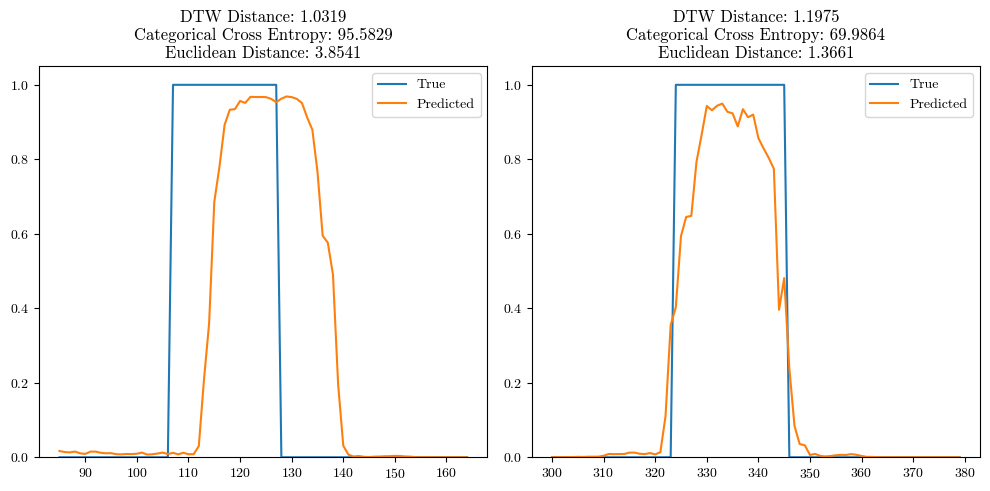

In [42]:
def euclid_and_dtw(a, b):
    dtw_dist = dtw(
        a, b, dist='square', method='fast',
        options={'radius': 1}, return_path=False
    )
    euclid_dist = np.linalg.norm(a - b)
    return euclid_dist, dtw_dist

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
s, f = 85, 165
a = y_true[s:f, 36]
b = y_pred[s:f, 36]
euclid_dist, dtw_dist = euclid_and_dtw(a, b)
cce = keras.losses.categorical_crossentropy(a, b)
axs[0].plot(range(s,f), a, label='True')
axs[0].plot(range(s,f), b, label='Predicted')
axs[0].set_ylim((0, 1.05))
axs[0].legend()
axs[0].set_title(f"DTW Distance: {dtw_dist:.4f}\nCategorical Cross Entropy: {cce:.4f}\nEuclidean Distance: {euclid_dist:.4f}")

s, f = 300, 380
a = y_true[s:f, 36]
b = y_pred[s:f, 36]
euclid_dist, dtw_dist = euclid_and_dtw(a, b)
cce = keras.losses.categorical_crossentropy(a, b)
axs[1].plot(range(s,f), a, label='True')
axs[1].plot(range(s,f), b, label='Predicted')
axs[1].set_ylim((0, 1.05))
axs[1].legend()
axs[1].set_title(f"DTW Distance: {dtw_dist:.4f}\nCategorical Cross Entropy: {cce:.4f}\nEuclidean Distance: {euclid_dist:.4f}")
plt.tight_layout()
# plt.savefig('../../report/final_pres/imgs/euclid_vs_dtw.pdf')
plt.show()


In [43]:
df_test = parse_csvs("../gesture_data/test/")
(_, _, _, _, _, X_test, y_test, _, _, _, _) = build_dataset(df_test, config)
y_test_pred = model.predict(X_test, verbose=0)
mean_dtw = dtw_evaluation(y_test, y_test_pred, i2g)


Making batches with window size of 23
Expanding labels to be in deltas of 10 before to 10 after


gesture0000: 11.4786: : 16500it [00:00, 50339.59it/s]                                        


gesture0000 0.09110013106859695


gesture0001: 11.0333: : 16500it [00:00, 56844.26it/s]                                        


gesture0001 0.07454905234560738


gesture0002: 9.3640: : 16500it [00:00, 57516.53it/s]                                         


gesture0002 0.062426811745111055


gesture0003: 20.6054: : 16500it [00:00, 57789.14it/s]                                        


gesture0003 0.1401727848709567


gesture0004: 13.9945: : 16500it [00:00, 57761.60it/s]                                        


gesture0004 0.09392303360815918


gesture0005: 12.7774: : 16500it [00:00, 58045.93it/s]                                        


gesture0005 0.08461868451363397


gesture0006: 9.7050: : 16500it [00:00, 57708.47it/s]                                         


gesture0006 0.06513438832101255


gesture0007: 9.1924: : 16500it [00:00, 57692.74it/s]                                         


gesture0007 0.061693627613461595


gesture0008: 7.9893: : 16500it [00:00, 57729.51it/s]                                         


gesture0008 0.05398157917219879


gesture0009: 8.7376: : 16500it [00:00, 58039.75it/s]                                         


gesture0009 0.05903757299961663


gesture0010: 17.1245: : 16500it [00:00, 57981.83it/s]                                        


gesture0010 0.11416345070832765


gesture0011: 15.3171: : 16500it [00:00, 57543.17it/s]                                        


gesture0011 0.10279959267529595


gesture0012: 18.8819: : 16500it [00:00, 58250.54it/s]                                        


gesture0012 0.12587947025348106


gesture0013: 22.7448: : 16500it [00:00, 58265.21it/s]                                        


gesture0013 0.1536807432751277


gesture0014: 25.5611: : 16500it [00:00, 57732.49it/s]                                        


gesture0014 0.1715507901862644


gesture0015: 11.9409: : 16500it [00:00, 58194.07it/s]                                        


gesture0015 0.0806819432515382


gesture0016: 10.5937: : 16500it [00:00, 58248.14it/s]                                        


gesture0016 0.07206619461933518


gesture0017: 12.3963: : 16500it [00:00, 58013.82it/s]                                        


gesture0017 0.08432832909933541


gesture0018: 10.6170: : 16500it [00:00, 58477.45it/s]                                        


gesture0018 0.07077976302567113


gesture0019: 9.6320: : 16500it [00:00, 58060.59it/s]                                         


gesture0019 0.06552399744190877


gesture0020: 13.2261: : 16500it [00:00, 59897.63it/s]                                        


gesture0020 0.08997316010484077


gesture0021: 15.2581: : 16500it [00:00, 60885.58it/s]                                        


gesture0021 0.10309540311452438


gesture0022: 16.3997: : 16500it [00:00, 61664.95it/s]                                        


gesture0022 0.11006502479675939


gesture0023: 12.6165: : 16500it [00:00, 61075.57it/s]                                        


gesture0023 0.08524653004765473


gesture0024: 22.2870: : 16500it [00:00, 60955.34it/s]                                        


gesture0024 0.1505879592804485


gesture0025: 14.5269: : 16500it [00:00, 57564.85it/s]                                        


gesture0025 0.09815496920014347


gesture0026: 13.1206: : 16500it [00:00, 60775.70it/s]                                        


gesture0026 0.08747034666029077


gesture0027: 12.5271: : 16500it [00:00, 59792.62it/s]                                        


gesture0027 0.0852180743117779


gesture0028: 14.2513: : 16500it [00:00, 59682.07it/s]                                        


gesture0028 0.0950086416619321


gesture0029: 15.1214: : 16500it [00:00, 59725.28it/s]                                        


gesture0029 0.10357115735309656


gesture0030: 8.7223: : 16500it [00:00, 60180.14it/s]                                         


gesture0030 0.05853892560546181


gesture0031: 12.6919: : 16500it [00:00, 60980.10it/s]                                        


gesture0031 0.085756013263317


gesture0032: 11.1040: : 16500it [00:00, 60581.83it/s]                                        


gesture0032 0.07502727518620404


gesture0033: 13.4042: : 16500it [00:00, 60737.03it/s]                                        


gesture0033 0.08996131528266216


gesture0034: 14.5332: : 16500it [00:00, 60857.52it/s]                                        


gesture0034 0.09886553882110488


gesture0035: 19.4665: : 16500it [00:00, 61031.09it/s]                                        


gesture0035 0.13242511145458571


gesture0036: 34.1147: : 16500it [00:00, 59326.70it/s]                                        


gesture0036 0.23207296831056087


gesture0037: 29.2529: : 16500it [00:00, 59599.42it/s]                                        


gesture0037 0.1976550330053409


gesture0038: 33.0059: : 16500it [00:00, 59226.42it/s]                                        


gesture0038 0.22301303674583856


gesture0039: 28.3159: : 16500it [00:00, 61508.86it/s]                                        


gesture0039 0.19003945846078693


gesture0040: 8.1929: : 16500it [00:00, 58988.40it/s]                                         


gesture0040 0.05573376722168246


gesture0041: 14.1181: : 16500it [00:00, 61205.21it/s]                                        


gesture0041 0.09412081344941688


gesture0042: 11.0149: : 16500it [00:00, 59727.19it/s]                                        


gesture0042 0.07392549309042232


gesture0043: 13.9892: : 16500it [00:00, 61219.23it/s]                                        


gesture0043 0.09516432189932941


gesture0044: 14.3211: : 16500it [00:00, 59570.64it/s]                                        


gesture0044 0.09808969222564835


gesture0045: 24.5677: : 16500it [00:00, 56528.12it/s]                                        


gesture0045 0.16488385420534654


gesture0046: 25.6877: : 16500it [00:00, 60072.32it/s]                                        


gesture0046 0.17240085745359285


gesture0047: 20.1553: : 16500it [00:00, 61671.60it/s]                                        


gesture0047 0.1361841715724023


gesture0048: 21.0980: : 16500it [00:00, 61748.30it/s]                                        


gesture0048 0.14255430909795191


gesture0049: 19.5419: : 16500it [00:00, 61170.91it/s]                                        


gesture0049 0.13293822775772823


gesture0255: 148.5110: : 16500it [00:00, 55851.71it/s]                                       

gesture0255 0.018591765276129577


# Plot conf mat on unseen data

In [44]:
np.argmax(y_test_pred, axis=1).shape, y_test.shape

((15379,), (15379,))

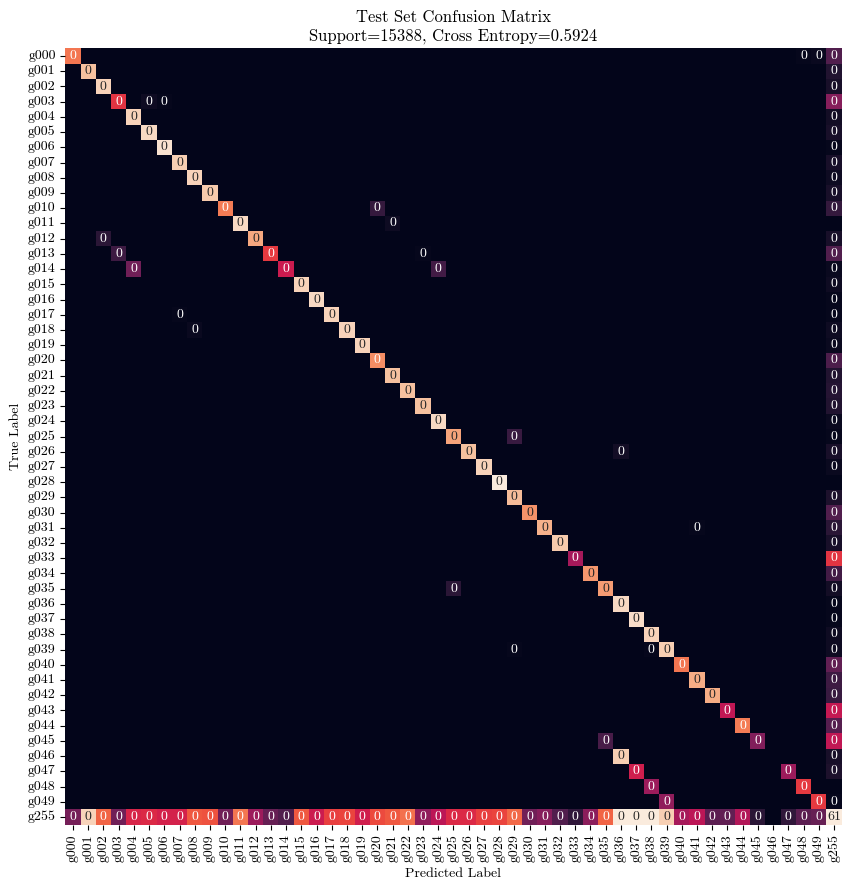

In [32]:
scce = keras.losses.sparse_categorical_crossentropy(
    y_test.astype(int), y_test_pred.astype(float),
).numpy().mean()

fig, ax = plt.subplots(1, 1, figsize=(9, 9))
_ = conf_mat(y_test, np.argmax(y_test_pred, axis=1), i2g, ax=ax, perc='both', cbar=False)
# valid_f1 = np.round(results["valid_f1"], 4)
# valid_scce = np.round(results["val_loss"], 4)
ax.set_title(
    f"Test Set Confusion Matrix\nSupport={len(y_test)}, Cross Entropy={scce:.4f}"
)
plt.tight_layout()
# plt.savefig(f"../../report/final_pres/imgs/test_confusion_matrices.pdf")


# Plot metrics on unseen data

In [45]:
dtws = {f'dtw.{i2g(i)}': d for i, d in enumerate(mean_dtw)}

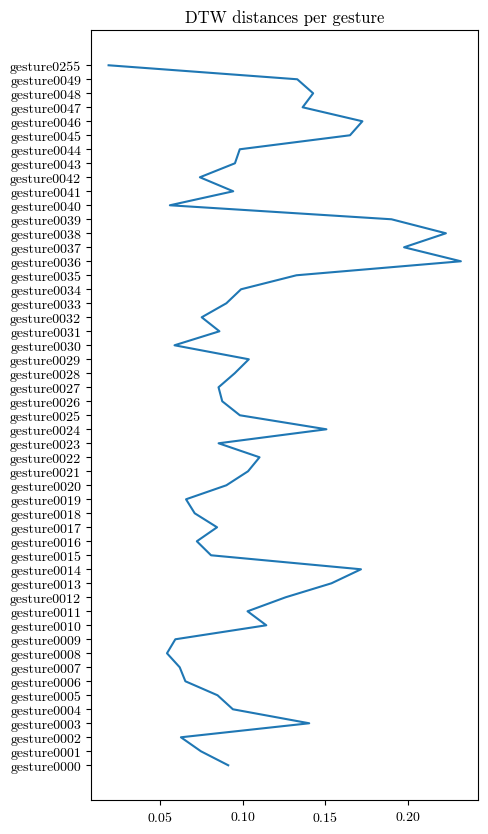

In [63]:
fig, ax = plt.subplots(figsize=(5, 10))
ax.plot( mean_dtw, range(len(mean_dtw)))

ax.set_yticks((list(range(len(np.unique(y))))))
ax.set_yticklabels(i2g(list(range(len(np.unique(y))))))

ax.set_title('DTW distances per gesture')
plt.show()

In [64]:
y_true = y_valid
y_pred = tf.one_hot(
    np.full(y_true.shape, g2i('gesture0255')), 
    len(np.unique(y_valid))
)
dumb_scce = keras.losses.sparse_categorical_crossentropy(
    y_true,
    y_pred,
).numpy().mean()
p, r, f1, sup = classification_report(y_true, np.argmax(y_pred, axis=-1), output_dict=True)['50'].values()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [69]:
@interact(start=widgets.IntSlider(
    value=275,
    min=0,
    max=y_pred.shape[0],
    step=100,
    description='Start',
    continuous_update=False,
), duration=widgets.IntSlider(
    value=20,
    min=0,
    max=5000,
    step=20,
    continuous_update=False,
    description='Duration',
))
def plt_preds(start, duration):
    s, f = start, start + duration
    fig, axs = plt.subplots(3, 1, figsize=(10, 5))
#     axs.formatter.use_mathtext = True
    onehot_valid = tf.one_hot(y[s:f], y_pred.shape[1]).numpy()
    
    axs[0].set_title('Actual gesture probabilities')
    sns.heatmap(
        onehot_valid.T,
        vmax=1,
        vmin=0,
        ax=axs[0]
    )

    axs[1].set_title('Predicted gesture probabilities')
    sns.heatmap(
        y_pred.numpy()[s:f].T,
        ax=axs[1],
        vmax=1,
        vmin=0,

    )

    axs[2].set_title('Actual gesture probabilities minus predicted gesture probabilities')
    sns.heatmap(
        onehot_valid.T - y_pred.numpy()[s:f].T,
        ax=axs[2],
        cmap='icefire',
        vmax=1,
        vmin=-1,

    )
    for ax in axs:
        ax.set_xticks([]) 
        ax.set_yticks([]) 
        ax.set_ylabel('Gesture')
    axs[-1].set_xlabel('Time')

    # plt.suptitle('Predicted and actual gestures over time')
    plt.tight_layout()


interactive(children=(IntSlider(value=275, continuous_update=False, description='Start', max=54056, step=100),…

### Make predictions and create a simplified confusion matrix

In [70]:
y_pred_valid = np.argmax(model.predict(X_valid, verbose=0), axis=1)

Text(0.5, 1.0, 'Percentage of observations classified correctly, as g255,\nor as some other gesture')

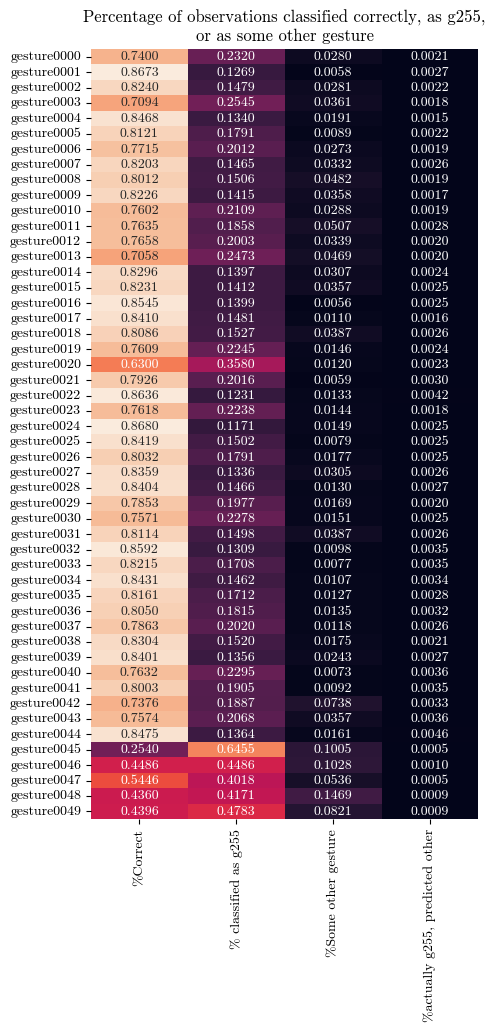

In [71]:
confusion_mtx = tf.math.confusion_matrix(y_valid, y_pred_valid).numpy()

df = pd.DataFrame()
df.index = i2g(list(range(len(confusion_mtx[0]))))
total_obs = pd.Series(confusion_mtx.sum(axis=1), index=df.index)
df['pred=true'] = np.diag(confusion_mtx) / total_obs
df['pred=g255'] = confusion_mtx[:, -1] / total_obs
df['pred!=true!=g255'] = (1 - df['pred=true'] - df['pred=g255'])

df['pred=other true=g255'] = confusion_mtx[-1, :] / total_obs[-1]
df
# total_obs


fig, ax = plt.subplots(1, 1, figsize=(5, 10))
sns.heatmap(
    df.iloc[:-1, :],
    xticklabels=['%Correct', '% classified as g255', '%Some other gesture', '%actually g255, predicted other'],
    ax=ax,
    annot=True,
    fmt='.4f',
    cbar=False,
)
plt.title('Percentage of observations classified correctly, as g255,\nor as some other gesture')

### Visualise predictions

In [72]:
# Visualise the predictions
all_gestures = [f'gesture{i:0>4}' for i in (list(range(50)) + [255])]
df = parse_csvs(root='../gesture_data/irl/')
# df = parse_csvs()
config, g2i, i2g, i2ohe, ohe2i, X, y, X_train, X_valid, y_train, y_valid = \
    build_dataset(df, config, gestures=all_gestures)

X = df.drop(['datetime', 'gesture'], axis=1).to_numpy()
y = df['gesture'].to_numpy()
t = df['datetime'].to_numpy()

batched_X, batched_y = make_batches(X, y, t, window_size=config['window_size'])

preds = model.predict(batched_X)

Making batches with window size of 23
Expanding labels to be in deltas of 10 before to 10 after
215/215 [==============================] - 1s 3ms/step


In [80]:
X.shape

(216223, 23, 30)

In [104]:
from matplotlib.gridspec import GridSpec
@interact(start=widgets.IntSlider(
    value=30,
    min=30,
    max=y.shape[0],
    step=20,
    description='Start',
    continuous_update=False,
), duration=widgets.IntSlider(
    value=500,
    min=0,
    max=1000,
    step=2,
    continuous_update=False,
    description='Duration',
))
def plt_preds(start, duration):
    s, f = start, min(len(df), start + duration)
    
    fig = plt.figure(figsize=(10, 7))
    gs = GridSpec(2, 1, height_ratios=(1, 6))

    hm = fig.add_subplot(gs[1:4, 0:3])
    probs = fig.add_subplot(gs[0, 0:3])

    n_ticks = 30
    skipby = len(t[s:f])//n_ticks
    xticklabels = [(str(t)[11:-6] if i%skipby==0 else '') for i, t in enumerate(t[s:f])]
    sns.heatmap(
        X[s:f, 0, :].T,
        xticklabels=xticklabels,
        ax=hm,
        cbar=None,
        vmax=900,
        vmin=300,
    )
    
    batched_X = np.empty((f-s, config['window_size'], X.shape[-1]))
    for i in range(0, f-s):
        batched_X[i] = X[s+i-config['window_size'] : s+i, 0, :]
    preds = model.predict(batched_X)
    
    cm = plt.get_cmap('tab20')
    NUM_COLORS = len(np.unique(config['gestures']))
    probs.set_prop_cycle(color=([cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]))
    colours = plt.get_cmap('tab10')
    
#     probs.set_prop_cycle(
#         color=['red', 'green', 'blue'], 
#         marker=['o', '+', 'x']
#     )
    for sty, pred in zip(final_cycler, preds.T):
    
        probs.plot(
            pred,
            lw=1,
            **(sty)
        )
    plt.setp(probs.get_xticklabels(), visible=False)
    hm.set_xlabel('Time')
    hm.set_ylabel('Sensor')
    probs.set_ylabel('Prediction\nprobability')
    plt.margins(x=0)
    
    labels = [
        'Left $0^{\circ}$',
        'Right $0^{\circ}$',
        'Left $45^{\circ}$',
        'Right $45^{\circ}$',
        'Left $90^{\circ}$',
        'Right $90^{\circ}$',
        'Left $135^{\circ}$',
        'Right $135^{\circ}$',
        'Left $180^{\circ}$',
        'Right $180^{\circ}$',
    ]
    legend_elements = [
        mpl.lines.Line2D([0], [0], label=label, **col)
        for label, col in zip(labels, cycler(color=[mpl.colormaps['tab20'](i) for i in range(10)]))
    ]

    # Create the figure
    # fig, ax = plt.subplots()
    hm.legend(handles=legend_elements, loc='right')

    
    plt.tight_layout()
    

interactive(children=(IntSlider(value=30, continuous_update=False, description='Start', max=216223, min=30, st…

In [76]:
# hidden
window_size = config['window_size']
@interact(idx=(2, len(df), 5))
def view_predictions(idx=window_size):
    if idx < 2*window_size or idx > len(df) - window_size:
        print(f"Clamping idx to between {2*window_size} and {len(df) - window_size}")
        idx = min(len(df) - window_size, max(idx, 2*window_size))
    
    y_orig = df['gesture'].to_numpy()
    X_orig = df.drop(['datetime', 'gesture'], axis=1).to_numpy()
    t_orig = df['datetime'].to_numpy()

    s, f = idx-window_size, idx+1#+window_size
    X_window = X[s:f]
    y_window = y[s:f]
    
    print(X_window.shape)
    shape = model.get_config()['layers'][0]['config']['batch_input_shape']
    assert shape[1] == X_window.shape[1] and shape[2] == X_window.shape[2], \
        f'Shape in config is not the shape of the model'
    proba_preds = model.predict(X_window, verbose=0)
    X_window = X_window[:, 0, :]
    
    mask = np.max(proba_preds, axis=1) < 0.0
    preds = i2g(np.argmax(proba_preds, axis=1))
    preds[mask] = 'gesture0255'
    preds = [g.replace('gesture0', 'g').replace('g255', '') for g in preds]

    fig, axs = plt.subplots(2, 1, figsize=(6, 7))
    sns.heatmap(
        X[idx].T,
        xticklabels=[g.replace('gesture0', 'g').replace('g255', '') for g in i2g(y_window)],
        ax=axs[0],
        cbar=None,
        vmax=900,
        vmin=300,
    )
    axs[0].set_xticklabels(
        [g.replace('gesture0', 'g').replace('g255', '') for g in i2g(y_window)],
        rotation=90
    )
    axs[0].set_title(f'Heatmap of Sensor measurements')
    axs[0].set_xlabel(f'Actual labels')
    axs[0].set_ylabel(f'Sensor')
    cm = plt.get_cmap('tab20')
    NUM_COLORS = len(np.unique(config['gestures']))
    
    axs[1].set_prop_cycle(color=([cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]))
    axs[1].plot(
        proba_preds, 
        label=i2g(config['gestures']),
    )
    axs[1].set_title(f'Lineplot of model predictions')
    axs[1].set_xticks(range(X[idx].shape[0]))
    axs[1].set_ylim((0, 1))
    axs[1].set_xlabel(f'Predicted Labels')
    axs[1].set_ylabel(f'Softmax of Final Layer')
    axs[1].set_xticklabels(preds[-X[idx].shape[0]:], rotation=90)
    plt.tight_layout()
    plt.show()

SyntaxError: 'return' outside function (208216443.py, line 1)

Making batches with window size of 23


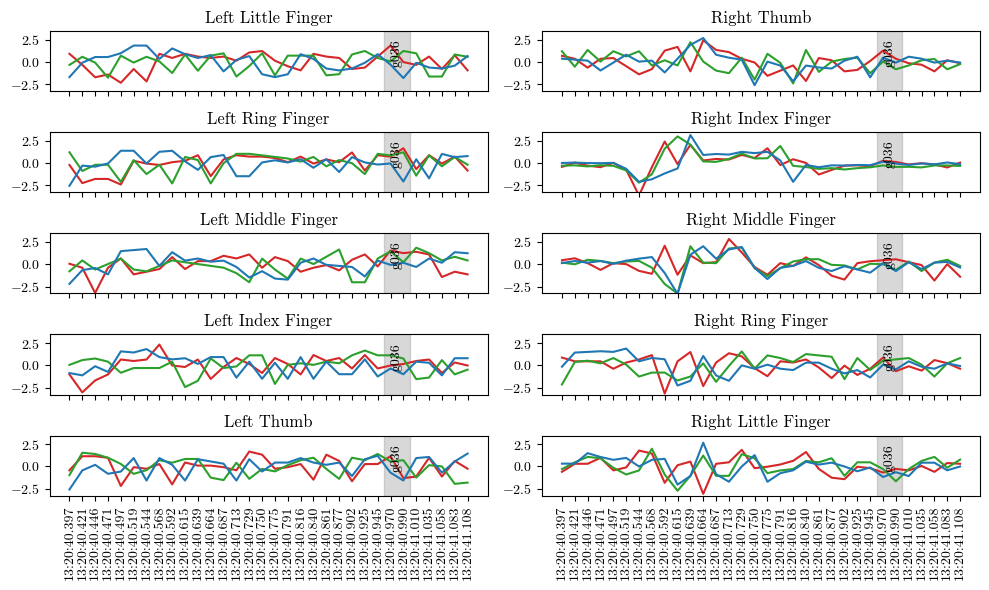

In [77]:
df = parse_csvs()
config, g2i, i2g, i2ohe, ohe2i, X, y, X_train, X_valid, y_train, y_valid = \
    build_dataset(df, config | {'label_expansion': 0})
idx = np.where(y == g2i('gesture0036'))[0][34]
s = idx-16 - 10
f = idx+16 - 10
labels = [str(dt).replace('2022-10-18 ', '')[:-3] for dt in df.iloc[s:f]['datetime']]
vals = X[s:f, -1, :]
normed = (vals - vals.mean(axis=0)) / vals.std(axis=0)

plot_timeseries(normed, i2g(y[s:f]), labels, per='finger')
plt.tight_layout()
# plt.savefig('../../report/imgs/gesture_over_time.pdf')

### Make figure for describing the training procedure

Making batches with window size of 14


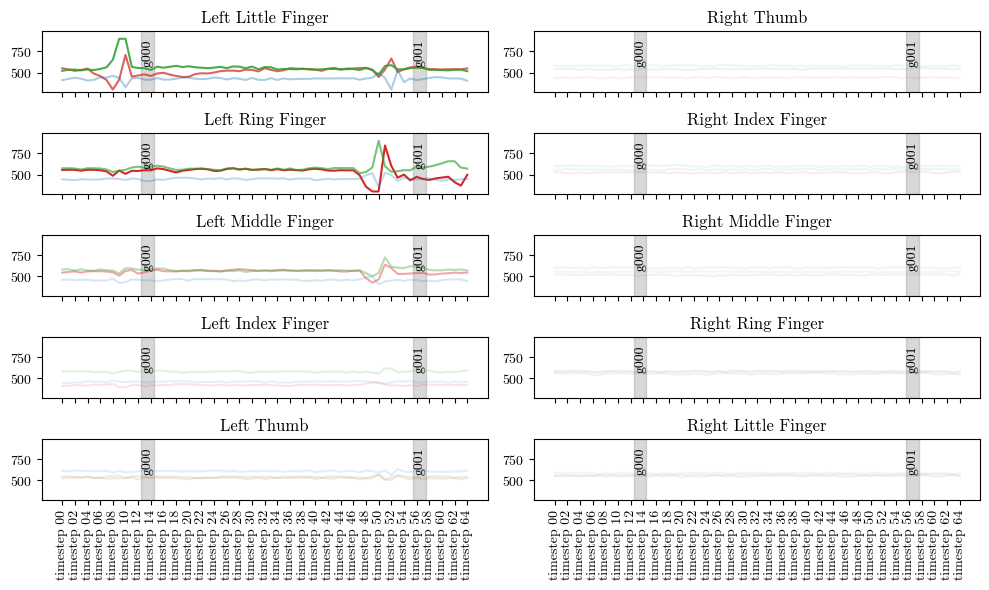

In [8]:
df = parse_csvs()
config, g2i, i2g, i2ohe, ohe2i, X, y, X_train, X_valid, y_train, y_valid = \
    build_dataset(df, config | {'label_expansion': 0})
idx = np.where(y == g2i('gesture0001'))[0][19]
s = idx-50 - 6
f = idx+15 - 6
# labels = [str(dt).replace('2022-10-08 ', '')[:-3] for dt in df.iloc[s:f]['datetime']]
labels = [f'timestep {i:0>2}' for i in range(len(df.iloc[s:f]['datetime']))]
vals = X[s:f, -1, :]
# normed = (vals - vals.mean(axis=0)) / vals.std(axis=0)

plot_timeseries(X=vals, y=i2g(y[s:f]), t=labels, per='finger')
plt.tight_layout()
plt.savefig('../../report/imgs/explain_recording_procedure_raw.pdf')

## Figure for comparing `window_size`

Making batches with window size of 10


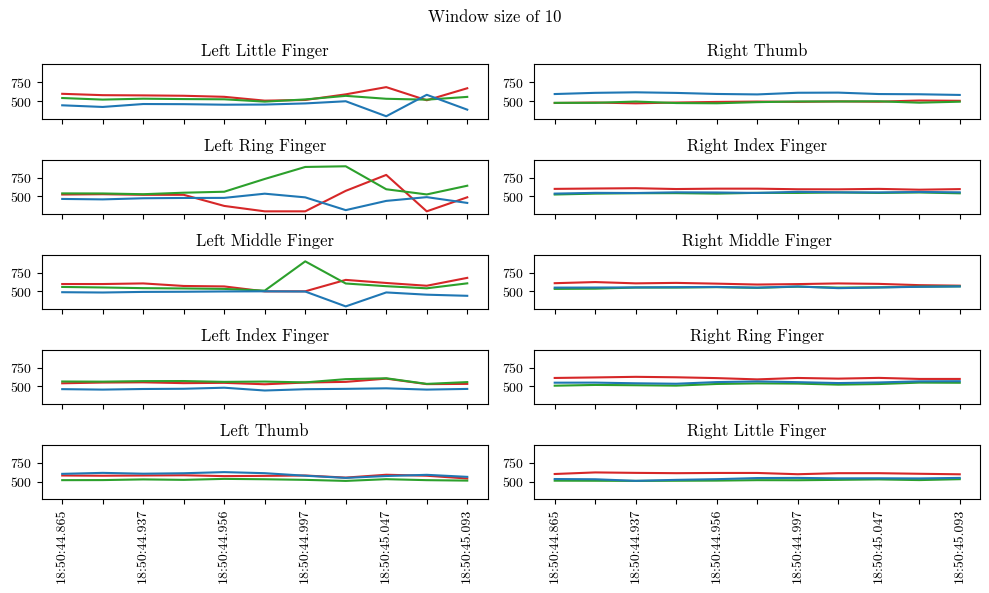

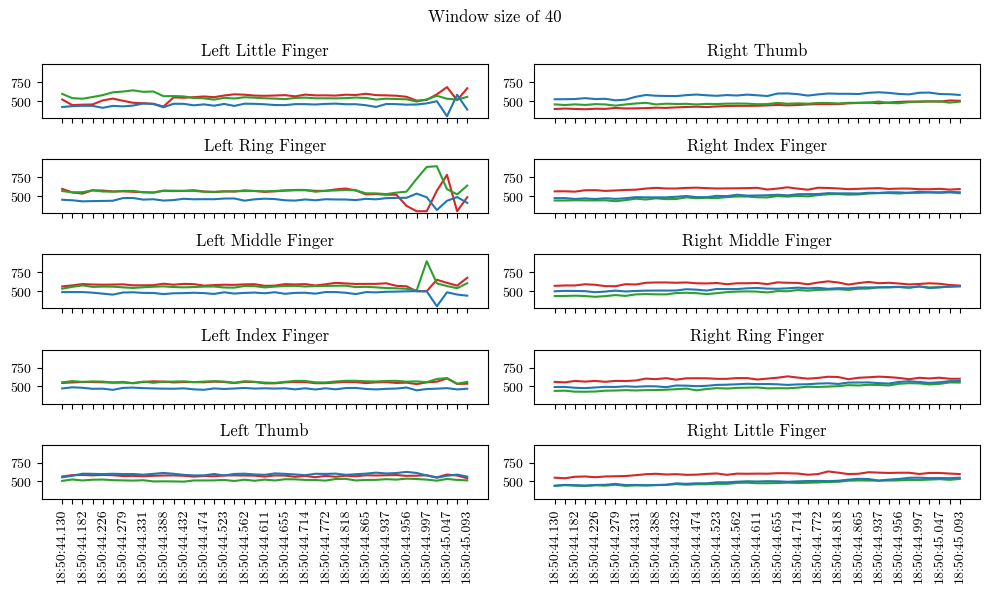

In [24]:
df = parse_csvs()
config, g2i, i2g, i2ohe, ohe2i, X, y, X_train, X_valid, y_train, y_valid = \
    build_dataset(df, config | {'label_expansion': 0, 'window_size': 10})
gesture = 'gesture0001'
idx = np.where(y == g2i(gesture))[0][100]

for window_size in (10, 40):
    s = idx - window_size
    f = idx + 1
    labels = [(str(dt)[11:-3] if i % 2 == 0 else '') for i, dt in enumerate(df.iloc[s:f]['datetime'])]
    vals = X[s:f, -1, :]
    yi = np.full((f - s,), 'gesture0255')

    plot_timeseries(X=vals, y=yi, t=labels, per='finger', alphatrick=False)
    plt.suptitle(f'Window size of {window_size}')
    plt.tight_layout()
    plt.savefig(f'../../report/final_pres/imgs/window_size_{window_size}.pdf')
    plt.show()
    

## Figure for describing the gestures

Making batches with window size of 10


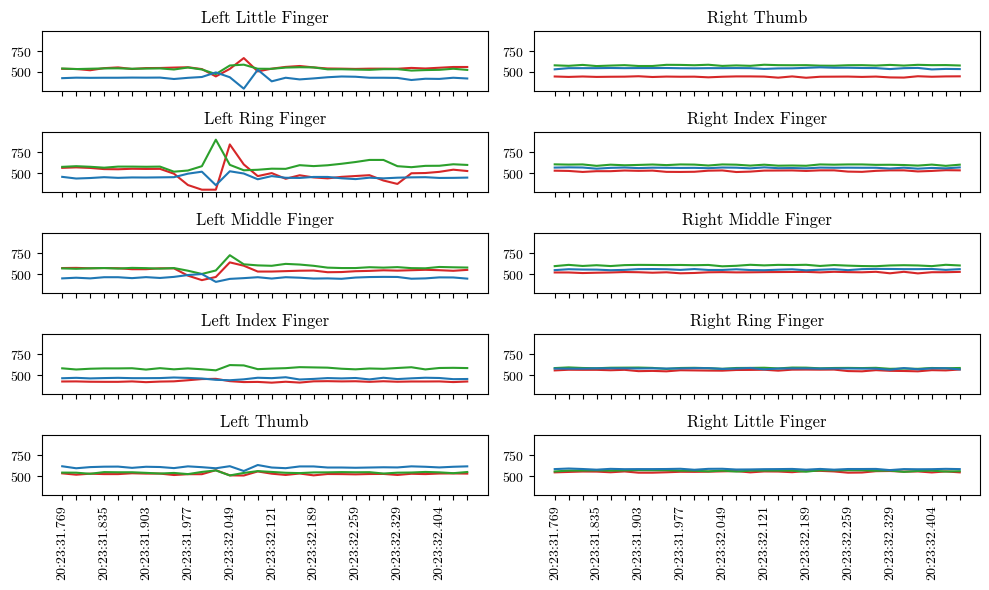

In [15]:
df = parse_csvs()
config, g2i, i2g, i2ohe, ohe2i, X, y, X_train, X_valid, y_train, y_valid = \
    build_dataset(df, config | {'label_expansion': 0})
gesture = 'gesture0001'
idx = np.where(y == g2i(gesture))[0][19]
s = idx - 15
f = idx + 15
# labels = [str(dt).replace('2022-10-08 ', '')[:-3] for dt in df.iloc[s:f]['datetime']]
labels = [(str(dt)[11:-3] if i % 3 == 0 else '') for i, dt in enumerate(df.iloc[s:f]['datetime'])]
vals = X[s:f, -1, :]

yi = np.full((f - s,), 'gesture0255')

plot_timeseries(X=vals, y=yi, t=labels, per='finger', alphatrick=False)
# plt.suptitle(f'Example of {gesture}')
plt.tight_layout()
plt.savefig('../../report/final_pres/imgs/gestures.pdf')

# Plot PCA of points

In [86]:
from cycler import cycler
m_left_cycle = cycler(marker=[
    "$5$",
    "$4$",
    "$3$",
    "$2$",
    "$1$",
])
m_right_cycle = cycler(marker=[
    "$1$",
    "$2$",
    "$3$",
    "$4$",
    "$5$",
])
marker_cycle = m_left_cycle.concat(m_right_cycle) * 5

cc = None
for c in cycler(color=[mpl.colormaps['tab20'](i) for i in range(10)]):
    if cc is None:
        cc = cycler('color', [c['color']]) * 5
    else:
        cc = cc.concat(cycler('color', [c['color']]) * 5)
final_cycler = cc + marker_cycle

In [87]:
config, g2i, i2g, i2ohe, ohe2i, X, y, X_train, X_valid, y_train, y_valid = \
    build_dataset(df, config | {'label_expansion': 0})


Making batches with window size of 23


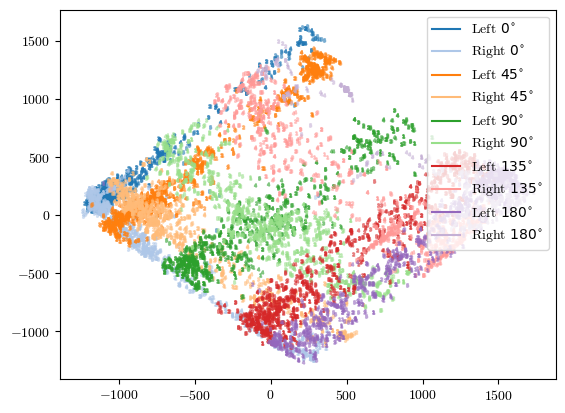

In [88]:
from cycler import cycler

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
df = parse_csvs()


LIMIT = -1

mask = (i2g(y) != 'gesture0255')

X_g = X[mask].reshape((X[mask].shape[0], -1))
y_g = y[mask]
X_g = X_g[:LIMIT, :]
y_g = y_g[:LIMIT]

# lda = LDA(n_components=2)
# X_r = lda.fit(X_g, y_g).transform(X_g)

pca = PCA(n_components=2)
X_r = pca.fit(X_g).transform(X_g)


fig = plt.figure()
ax = fig.add_subplot()

for style, g in zip(final_cycler, np.unique(y_g)):
    ax.scatter(
        X_r[y_g == g, 0][:1000], 
        X_r[y_g == g, 1][:1000], 
#         X_r[y_g == g, 2][:10], 
        label=i2g(g),
        alpha=0.5,
        s=5,
        **style
    )

labels = [
    'Left $0^{\circ}$',
    'Right $0^{\circ}$',
    'Left $45^{\circ}$',
    'Right $45^{\circ}$',
    'Left $90^{\circ}$',
    'Right $90^{\circ}$',
    'Left $135^{\circ}$',
    'Right $135^{\circ}$',
    'Left $180^{\circ}$',
    'Right $180^{\circ}$',
]
legend_elements = [
    mpl.lines.Line2D([0], [0], label=label, **col)
    for label, col in zip(labels, cycler(color=[mpl.colormaps['tab20'](i) for i in range(10)]))
]

# Create the figure
# fig, ax = plt.subplots()
plt.legend(handles=legend_elements, loc='best')
# plt.legend()
# plt.savefig('../../report/final_pres/imgs/secret_pca.pdf')

## Weights And Biases Hyperparameter Sweeps

In [31]:

with open('sweep.yaml', "r") as file:
    sweep_config = yaml.safe_load(file)
sweep_id = wandb.sweep(sweep_config, project="ergo")

Create sweep with ID: 6wrbpxqx
Sweep URL: https://wandb.ai/beyarkay/ergo/sweeps/6wrbpxqx
